# DACON 컴퓨터 비전 학습 경진대회
### 2020.08.03 ~ 2020.09.14 17:59

## Python import

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier 
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score

## Load Data
#### make data from .csv

In [20]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## EDA(Exploratory Data Analysis, 탐색적 데이터 분석)
#### visualize data and find the feature

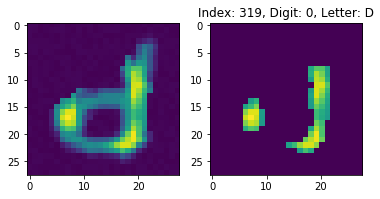

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   

In [21]:
idx = 319
img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
digit = train.loc[idx, 'digit']
letter = train.loc[idx, 'letter']

plt.subplot(121)
plt.imshow(img)

for n, i in enumerate(img):
    for m, j in enumerate(i):
        if img[n][m] < 10:
            img[n][m] = img[n][m]*0.1
            
        if img[n][m] < 135:
            img[n][m] = 0
        

plt.subplot(122)
plt.title('Index: %i, Digit: %s, Letter: %s'%(idx, digit, letter))
plt.imshow(img)
plt.show()

print(img)

## Preprocessing
#### add feature image to the second channel of data.(data becomes (-1, 28, 28, 2))

In [22]:
x = train.drop(['id', 'digit', 'letter'], axis=1).values
x = x.reshape(-1, 28, 28, 1)

x = np.delete(x, (0), axis=1)
x = np.delete(x, (-1), axis=1)
x = np.delete(x, (0), axis=2)
x = np.delete(x, (-1), axis=2)


print(x.shape)

(2048, 26, 26, 1)


In [5]:
# This cell add feature channel(only digit pixels data) to the x_train. (x_train becomes (-1,28,28,2))

x_preprocessing = np.array(np.zeros(x_train.shape))

for p, img in enumerate(x):
    for q, i in enumerate(img):
        for r, j in enumerate(i):
            if img[q][r] < 135:
                x_preprocessing[p][q][r] = 0
                
x = np.concatenate((x, x_preprocessing), axis=3)

NameError: name 'x_train' is not defined

In [23]:
x = x/255

y_data = train['digit']
y = np.zeros((len(y_data), len(y_data.unique())))
for i, digit in enumerate(y_data):
    y[i, digit] = 1

In [24]:
x_val = x[-int(len(x)*0.2):]
y_val = y[-int(len(y)*0.2):]
x_train = x[:-int(len(x)*0.2)]
y_train = y[:-int(len(y)*0.2)]

print(str(x.shape))
print(str(y.shape))
print(str(x_val.shape))
print(str(y_val.shape))
print(str(x_train.shape))
print(str(y_train.shape))

(2048, 26, 26, 1)
(2048, 10)
(409, 26, 26, 1)
(409, 10)
(1639, 26, 26, 1)
(1639, 10)


In [40]:
def create_cnn_model(x_train):
    inputs = tf.keras.layers.Input(x_train.shape[1:])

    bn = tf.keras.layers.BatchNormalization()(inputs)
    conv = tf.keras.layers.Conv2D(128,kernel_size=5, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    bn = tf.keras.layers.BatchNormalization()(pool)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu', kernel_initializer='he_normal',kernel_regularizer =keras.regularizers.l2( l=0.01))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu', kernel_initializer='he_normal',kernel_regularizer =keras.regularizers.l2( l=0.01))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    flatten = tf.keras.layers.Flatten()(pool)

    bn = tf.keras.layers.BatchNormalization()(flatten)
    dense = tf.keras.layers.Dense(1000, activation='relu', kernel_initializer='he_normal',kernel_regularizer =keras.regularizers.l2( l=0.01))(bn)

    bn = tf.keras.layers.BatchNormalization()(dense)
    outputs = tf.keras.layers.Dense(10, activation='softmax', kernel_initializer= 'glorot_normal')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model
    


In [41]:
MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_accuracy:.4f}-{val_loss:.4f}.hdf5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_accuracy', verbose=1, save_best_only = True)

In [42]:
def scheduler(epoch, lr):
  if epoch < 80:
    return lr
  elif epoch >150:
      return lr *0.01
  else:
    return lr*0.85
lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

In [43]:
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train_range, test_range in kfold.split(x, y):
    print(train_range)


[   0    1    2 ... 2045 2046 2047]
[   0    2    3 ... 2045 2046 2047]
[   0    1    2 ... 2043 2046 2047]
[   1    2    3 ... 2043 2044 2045]
[   0    1    3 ... 2045 2046 2047]


In [44]:
# Define per-fold score containers
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train_range, val_range in kfold.split(x, y):

  # Define the model architecture
  model = create_cnn_model(x[train_range])

  # Compile the model
  model.compile(
      loss='categorical_crossentropy',
      optimizer=keras.optimizers.Adam(learning_rate=0.001),
      metrics=['accuracy'])


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  epochs=120
  history = model.fit(x[train_range], y[train_range], validation_data= (x[val_range], y[val_range]), epochs=epochs, callbacks=[cb_checkpoint, lr_scheduler])

  # Generate generalization metrics
  scores = model.evaluate(x[val_range], y[val_range], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1

# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

=======>.] - ETA: 0s - loss: 1.3900 - accuracy: 0.9281
Epoch 00056: val_accuracy did not improve from 0.83902
1639/1639 [==============================] - 2s 1ms/sample - loss: 1.3955 - accuracy: 0.9256 - val_loss: 2.1380 - val_accuracy: 0.7384
Epoch 57/120
1632/1639 [============================>.] - ETA: 0s - loss: 1.7779 - accuracy: 0.9154
Epoch 00057: val_accuracy did not improve from 0.83902
1639/1639 [==============================] - 2s 1ms/sample - loss: 1.7770 - accuracy: 0.9152 - val_loss: 2.8327 - val_accuracy: 0.6650
Epoch 58/120
1632/1639 [============================>.] - ETA: 0s - loss: 1.6449 - accuracy: 0.9210
Epoch 00058: val_accuracy did not improve from 0.83902
1639/1639 [==============================] - 2s 1ms/sample - loss: 1.6434 - accuracy: 0.9213 - val_loss: 2.0728 - val_accuracy: 0.7775
Epoch 59/120
1632/1639 [============================>.] - ETA: 0s - loss: 1.3696 - accuracy: 0.9320
Epoch 00059: val_accuracy did not improve from 0.83902
1639/1639 [=========

In [27]:
print(scores)

[1.0591422905257395, 0.9608802]


## Train model

In [11]:
def create_cnn_model(x_train):
    inputs = tf.keras.layers.Input(x_train.shape[1:])

    bn = tf.keras.layers.BatchNormalization()(inputs)
    conv = tf.keras.layers.Conv2D(128,kernel_size=5, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu', kernel_initializer='he_normal')(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    bn = tf.keras.layers.BatchNormalization()(pool)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu', kernel_initializer='he_normal',kernel_regularizer =keras.regularizers.l2( l=0.01))(bn)
    bn = tf.keras.layers.BatchNormalization()(conv)
    conv = tf.keras.layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu', kernel_initializer='he_normal',kernel_regularizer =keras.regularizers.l2( l=0.01))(bn)
    pool = tf.keras.layers.MaxPooling2D((2, 2))(conv)

    flatten = tf.keras.layers.Flatten()(pool)

    bn = tf.keras.layers.BatchNormalization()(flatten)
    dense = tf.keras.layers.Dense(1000, activation='relu', kernel_initializer='he_normal',kernel_regularizer =keras.regularizers.l2( l=0.01))(bn)

    bn = tf.keras.layers.BatchNormalization()(dense)
    outputs = tf.keras.layers.Dense(10, activation='softmax', kernel_initializer= 'glorot_normal')(bn)

    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)

    return model
    
model = create_cnn_model(x_train)

In [25]:
num_classes = 10

model = Sequential([
  layers.Input(x_train.shape[1:]),

  layers.BatchNormalization(),
  layers.Conv2D(128, kernel_size=5, strides=1, padding='same', activation='relu', kernel_initializer='he_normal'),
  layers.BatchNormalization(),
  layers.Conv2D(128, kernel_size=2, strides=1, padding='same', activation='relu', kernel_initializer='he_normal'),
  layers.MaxPooling2D((2,2)),
  layers.Dropout(0.25),

  layers.BatchNormalization(),
  layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu', kernel_initializer='he_normal',kernel_regularizer =keras.regularizers.l2( l=0.01)),
  layers.BatchNormalization(),
  layers.Conv2D(256, kernel_size=2, strides=1, padding='same', activation='relu', kernel_initializer='he_normal',kernel_regularizer =keras.regularizers.l2( l=0.01)),
  layers.MaxPooling2D((2,2)),
  layers.Dropout(0.25),

  layers.Flatten(),

  layers.BatchNormalization(),
  layers.Dense(1000, activation='relu', kernel_initializer='he_normal',kernel_regularizer =keras.regularizers.l2( l=0.01)),
  
  layers.BatchNormalization(),
  layers.Dense(num_classes, activation='softmax', kernel_initializer= 'glorot_normal')
])

In [26]:
datagen = keras.preprocessing.image.ImageDataGenerator(
    # featurewise_center=True,
    featurewise_std_normalization=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=5
    )

In [33]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
    )

### Callbacks

In [30]:
MODEL_SAVE_FOLDER_PATH = './model/'
if not os.path.exists(MODEL_SAVE_FOLDER_PATH):
    os.mkdir(MODEL_SAVE_FOLDER_PATH)

model_path = MODEL_SAVE_FOLDER_PATH + '{epoch:02d}-{val_accuracy:.4f}-{val_loss:.4f}.hdf5'

cb_checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_accuracy', verbose=1, save_best_only = True)

In [12]:
def scheduler(epoch, lr):
  if epoch < 80:
    return lr
  elif epoch >150:
      return lr *0.01
  else:
    return lr*0.85     # lr 0.8이 최적의 값(0.001*0.8=0.0008)
lr_scheduler = keras.callbacks.LearningRateScheduler(scheduler)

## Train model
#### using variation of baseline model
#### + add kernel_initializer='he_normal'
#### + add kernel_regularizer =keras.regularizers.l2( l=0.01)
#### + add kernel_initializer= 'glorot_normal'
#### .
#### first cell is 'add type' model
#### second cell is 'sequential type' model

In [34]:
epochs=120
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, callbacks=[cb_checkpoint,lr_scheduler])

Train on 1639 samples, validate on 409 samples
Epoch 1/60
1632/1639 [============================>.] - ETA: 0s - loss: 0.4975 - accuracy: 0.9773
Epoch 00001: val_accuracy did not improve from 0.85086
1639/1639 [==============================] - 4s 2ms/sample - loss: 0.4976 - accuracy: 0.9774 - val_loss: 0.8834 - val_accuracy: 0.8509
Epoch 2/60
1632/1639 [============================>.] - ETA: 0s - loss: 0.4740 - accuracy: 0.9822
Epoch 00002: val_accuracy improved from 0.85086 to 0.85819, saving model to ./model/02-0.8582-0.8631.hdf5
1639/1639 [==============================] - 4s 2ms/sample - loss: 0.4739 - accuracy: 0.9823 - val_loss: 0.8631 - val_accuracy: 0.8582
Epoch 3/60
1632/1639 [============================>.] - ETA: 0s - loss: 0.4305 - accuracy: 0.9908
Epoch 00003: val_accuracy did not improve from 0.85819
1639/1639 [==============================] - 2s 1ms/sample - loss: 0.4305 - accuracy: 0.9908 - val_loss: 0.7945 - val_accuracy: 0.8582
Epoch 4/60
1600/1639 [================

In [28]:
epochs=120
history = model.fit_generator(
    datagen.flow(x_train, y_train, batch_size=32),
    steps_per_epoch=len(x_train) / 32,
    validation_data=(x_val, y_val), 
    epochs = epochs,
    callbacks=[cb_checkpoint, lr_scheduler])

1008 - val_accuracy: 0.5892
Epoch 50/120
51/51 [============================>.] - ETA: 0s - loss: 2.7982 - accuracy: 0.6447
Epoch 00050: val_accuracy did not improve from 0.86797
52/51 [==============================] - 2s 45ms/step - loss: 2.8042 - accuracy: 0.6425 - val_loss: 2.7856 - val_accuracy: 0.6430
Epoch 51/120
50/51 [============================>.] - ETA: 0s - loss: 2.9555 - accuracy: 0.6171
Epoch 00051: val_accuracy did not improve from 0.86797
52/51 [==============================] - 2s 45ms/step - loss: 2.9557 - accuracy: 0.6150 - val_loss: 2.7691 - val_accuracy: 0.6577
Epoch 52/120
51/51 [============================>.] - ETA: 0s - loss: 2.8153 - accuracy: 0.6385
Epoch 00052: val_accuracy did not improve from 0.86797
52/51 [==============================] - 2s 44ms/step - loss: 2.8160 - accuracy: 0.6394 - val_loss: 2.8840 - val_accuracy: 0.6455
Epoch 53/120
51/51 [============================>.] - ETA: 0s - loss: 2.8146 - accuracy: 0.6550
Epoch 00053: val_accuracy did not

## Check the History

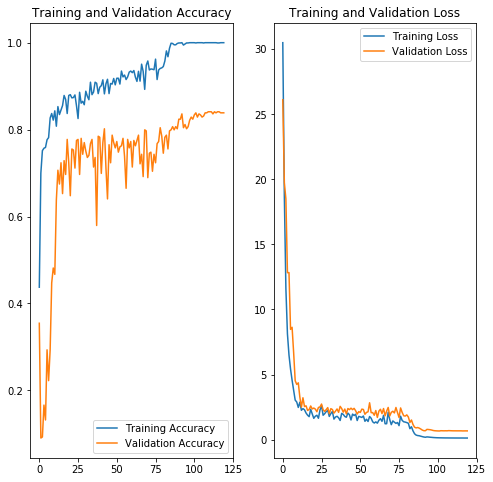

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict

In [46]:
model = keras.models.load_model('./model/ScaleUpDatagenNormalfit06-0.8680-0.7251.hdf5')

In [47]:
x_test = test.drop(['id', 'letter'], axis=1).values
x_test = x_test.reshape(-1, 28, 28, 1)
x_test = x_test/255

x_test = np.delete(x_test, (0), axis=1)
x_test = np.delete(x_test, (-1), axis=1)
x_test = np.delete(x_test, (0), axis=2)
x_test = np.delete(x_test, (-1), axis=2)

submission = pd.read_csv('data/submission.csv')
submission['digit'] = np.argmax(model.predict(x_test), axis=1)
submission.head()

,id,digit
0,2049,6
1,2050,8
2,2051,8
3,2052,0
4,2053,3


In [48]:
submission.to_csv('08291040(ScaleUpDatagenNormalfit06-0.8680-0.7251).csv', index=False)